# FFIEC Data Connect - Comprehensive Demo

This notebook demonstrates all the capabilities of the FFIEC Data Connect library, including:
- Basic data collection (sync)
- Async data collection with rate limiting
- Parallel processing for multiple data requests
- Working with pandas and polars DataFrames
- Error handling and validation
- Performance comparisons

## 🚀 Quick Start

1. **First**: Run the installation cell above to install all required packages
2. **Second**: Enter your FFIEC credentials when prompted (or set environment variables)
3. **Then**: Run all remaining cells to see the full demonstration

## 📋 Requirements

- Python 3.8+
- Valid FFIEC CDR credentials (or demo mode will be used)
- Internet connection for package installation

**Note**: If you have FFIEC credentials, the notebook will collect real data. Otherwise, it will demonstrate all features using mock data.

## 📦 Setup and Imports

In [1]:
# Standard library imports
import os
import asyncio
import time
import random
from datetime import datetime, timedelta
from typing import List, Dict, Any

# Third-party imports
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# FFIEC Data Connect imports
import ffiec_data_connect as fdc
from ffiec_data_connect import (
    WebserviceCredentials,
    FFIECConnection,
    AsyncCompatibleClient,
    RateLimiter,
    collect_data,
    collect_reporting_periods,
    collect_filers_on_reporting_period,
    collect_filers_since_date,
    collect_filers_submission_date_time,
    CredentialError,
    ValidationError,
    NoDataError
)

print(f"FFIEC Data Connect version: {fdc.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Polars version: {pl.__version__}")

FFIEC Data Connect version: 2.0.0rc4
Pandas version: 2.3.1
Polars version: 1.32.2


In [2]:
# Cell removed - AsyncCompatibleClient will be created later in the connection management section

In [3]:
# Interactive credential input
print("🔐 FFIEC CDR Credentials")
print("Enter your credentials:")

import getpass

username = input("Username: ").strip()
password = getpass.getpass("Password: ")

credentials = WebserviceCredentials(username, password)
print(f"✅ Credentials set for: {credentials.username}")

# Alternative: Environment variables (uncomment to use instead)
# credentials = WebserviceCredentials()  # Uses FFIEC_USERNAME and FFIEC_PASSWORD env vars

🔐 FFIEC CDR Credentials
Enter your credentials:
✅ Credentials set for: cfs111


## 🔌 Connection Management

The library provides multiple connection management approaches:
- Basic FFIECConnection
- AsyncCompatibleClient with advanced features
- Context managers for automatic cleanup

In [4]:
# Basic connection
basic_connection = FFIECConnection()
print(f"Basic connection: {basic_connection}")
print(f"Session active: {basic_connection.session is not None}")

# Advanced async-compatible client with rate limiting
async_client = AsyncCompatibleClient(
    credentials=credentials,
    max_concurrent=4,  # Max 4 concurrent requests
    rate_limit=0.5  # Max 0.5 requests per second (30 per minute)
)

print(f"\nAsync client: {async_client}")
print(f"Rate limiter: {async_client.rate_limiter}")

# Context manager usage (recommended)
print("\n🔄 Testing context manager...")
with AsyncCompatibleClient(credentials) as client:
    print(f"Client active: {len(client._connection_cache) >= 0}")  # Check cache exists
print("Client automatically closed after context")

Basic connection: FFIECConnection(
  session_status=inactive,
  proxy_enabled=False,
  proxy_host='None',
  proxy_port=None,
  proxy_protocol=None,
  proxy_username='None',
  proxy_password_set=False
)
Session active: True

Async client: <ffiec_data_connect.async_compatible.AsyncCompatibleClient object at 0x11f6f6120>
Rate limiter: <ffiec_data_connect.async_compatible.RateLimiter object at 0x11f6f6270>

🔄 Testing context manager...
Client active: True
Client automatically closed after context


## 📊 Basic Data Collection (Synchronous)

Start with the traditional synchronous API for collecting FFIEC data.

In [5]:
# Sample data for examples
SAMPLE_BANKS = ["480228", "852320"]  # JPMorgan Chase, Bank of America  
SAMPLE_PERIODS = ["2023-12-31", "2023-09-30"]

print(f"Sample banks (RSSD IDs): {SAMPLE_BANKS}")
print(f"Sample periods: {SAMPLE_PERIODS}")

Sample banks (RSSD IDs): ['480228', '852320']
Sample periods: ['2023-12-31', '2023-09-30']


In [6]:
# 1. Get available reporting periods
print("📅 Getting available reporting periods...")

try:
    periods = collect_reporting_periods(
        session=basic_connection.session,
        creds=credentials,
        series="call",
        output_type="list"
    )
    
    print(f"Found {len(periods)} reporting periods")
    print("Recent periods:")
    for period in periods[:5]:  # Show first 5
        print(f"  - {period}")
        
except Exception as e:
    print(f"Error getting periods: {e}")
    periods = SAMPLE_PERIODS  # Fallback

📅 Getting available reporting periods...
Found 98 reporting periods
Recent periods:
  - 6/30/2025
  - 3/31/2025
  - 12/31/2024
  - 9/30/2024
  - 6/30/2024


In [7]:
# 2. Collect data for a single bank
print("🏦 Collecting data for a single bank...")

rssd_id = SAMPLE_BANKS[0]  # JPMorgan Chase
reporting_period = SAMPLE_PERIODS[0]  # Most recent

print(f"Bank RSSD ID: {rssd_id}")
print(f"Reporting period: {reporting_period}")

try:
    start_time = time.time()
    
    bank_data = collect_data(
        session=basic_connection.session,
        creds=credentials,
        reporting_period=reporting_period,
        rssd_id=rssd_id,
        series="call",
        output_type="list"
    )
    
    elapsed = time.time() - start_time
    
    print(f"✅ Collected {len(bank_data)} data points in {elapsed:.2f} seconds")
    
    # Show sample data
    if bank_data:
        print("\nSample data points:")
        for i, item in enumerate(bank_data[:3]):
            print(f"  {i+1}. {item}")
            
except Exception as e:
    print(f"❌ Error collecting data: {e}")
    bank_data = []

🏦 Collecting data for a single bank...
Bank RSSD ID: 480228
Reporting period: 2023-12-31
✅ Collected 2033 data points in 0.10 seconds

Sample data points:
  1. {'mdrm': 'TE03N528', 'rssd': '480228', 'quarter': '12/31/2023', 'data_type': 'str', 'int_data': nan, 'float_data': nan, 'bool_data': nan, 'str_data': 'www.mymerrill.com'}
  2. {'mdrm': 'TE03N529', 'rssd': '480228', 'quarter': '12/31/2023', 'data_type': 'str', 'int_data': nan, 'float_data': nan, 'bool_data': nan, 'str_data': 'BofA'}
  3. {'mdrm': 'RCFDC222', 'rssd': '480228', 'quarter': '12/31/2023', 'data_type': 'int', 'int_data': np.int64(2981000), 'float_data': nan, 'bool_data': nan, 'str_data': None}


In [8]:
# 5. Get detailed submission timestamps for banks
print("⏰ Getting bank submission timestamps...")

try:
    # Use the same date range as above
    submission_info = collect_filers_submission_date_time(
        session=basic_connection.session,
        creds=credentials,
        since_date='12/31/2023',
        reporting_period=SAMPLE_PERIODS[0],
        output_type="pandas"  # This returns detailed timestamp data
    )
    
    if isinstance(submission_info, pd.DataFrame) and len(submission_info) > 0:
        print(f"✅ Found submission details for {len(submission_info)} filings")
        print(f"Columns: {submission_info.columns.tolist()}")
        
        # Show sample submission data
        print("\nSample submission timestamps:")
        print(submission_info.head())
        
        # Summary statistics if we have timestamp data
        if 'submission_date' in submission_info.columns or any('date' in col.lower() for col in submission_info.columns):
            print("\n📊 Submission timing analysis:")
            date_cols = [col for col in submission_info.columns if 'date' in col.lower() or 'time' in col.lower()]
            if date_cols:
                print(f"Date/time columns available: {date_cols}")
    else:
        print(f"✅ Got submission info: {type(submission_info)} with {len(submission_info) if hasattr(submission_info, '__len__') else 'N/A'} items")
        if hasattr(submission_info, '__iter__') and len(str(submission_info)) < 500:
            print(f"Sample data: {list(submission_info)[:3] if hasattr(submission_info, '__iter__') else submission_info}")
    
except Exception as e:
    print(f"❌ Error getting submission timestamps: {e}")
    submission_info = []

⏰ Getting bank submission timestamps...
✅ Found submission details for 4641 filings
Columns: ['rssd', 'datetime']

Sample submission timestamps:
      rssd              datetime
0  3358270  2/20/2024 3:23:30 PM
1  2132941  1/26/2024 7:24:57 AM
2  1447639  7/18/2024 7:26:03 PM
3   988153  1/26/2024 5:58:00 PM
4  5313312  4/12/2024 2:50:42 PM

📊 Submission timing analysis:
Date/time columns available: ['datetime']


In [9]:
# 4. Get banks that have filed since a specific date
print("📅 Getting banks that filed since a specific date...")

# Use a date 30 days before the reporting period
from datetime import datetime, timedelta
try:
    reporting_date = datetime.strptime(SAMPLE_PERIODS[0], "%Y-%m-%d")
    since_date = reporting_date - timedelta(days=30)
    since_date_str = since_date.strftime("%Y-%m-%d")
    
    print(f"Looking for filings since: {since_date_str}")
    
    recent_filers = collect_filers_since_date(
        session=basic_connection.session,
        creds=credentials,
        reporting_period=SAMPLE_PERIODS[0],
        since_date=since_date_str,
        output_type="list"
    )
    
    print(f"✅ Found {len(recent_filers)} banks that filed since {since_date_str}")
    
    # Show sample recent filers
    if recent_filers:
        print("\nRecent filers (sample):")
        for i, filer in enumerate(recent_filers[:5]):  # Show first 5
            print(f"  {i+1}. RSSD ID: {filer}")
    
except Exception as e:
    print(f"❌ Error getting recent filers: {e}")
    recent_filers = []

📅 Getting banks that filed since a specific date...
Looking for filings since: 2023-12-01
✅ Found 4641 banks that filed since 2023-12-01

Recent filers (sample):
  1. RSSD ID: 3358270
  2. RSSD ID: 2132941
  3. RSSD ID: 1447639
  4. RSSD ID: 988153
  5. RSSD ID: 5313312


In [10]:
# 3. Get all banks that filed for a specific reporting period
print("🏢 Getting all filers for a reporting period...")

try:
    filers = collect_filers_on_reporting_period(
        session=basic_connection.session,
        creds=credentials,
        reporting_period=SAMPLE_PERIODS[0],
        output_type="list"
    )
    
    print(f"✅ Found {len(filers)} banks that filed for {SAMPLE_PERIODS[0]}")
    
    # Show sample filers
    if filers:
        print("\nSample filers:")
        for i, filer in enumerate(filers[:5]):  # Show first 5
            print(f"  {i+1}. RSSD ID: {filer}")
    
    # Store for later use
    available_filers = filers[:10] if filers else SAMPLE_BANKS
    
except Exception as e:
    print(f"❌ Error getting filers: {e}")
    available_filers = SAMPLE_BANKS

🏢 Getting all filers for a reporting period...
✅ Found 4641 banks that filed for 2023-12-31

Sample filers:
  1. RSSD ID: {'id_rssd': '718275', 'fdic_cert_number': '26539', 'occ_chart_number': None, 'ots_dock_number': None, 'primary_aba_rout_number': None, 'name': 'BANK OF THE FEDERATED STATES OF MICRONESIA', 'state': '0', 'city': 'POHNPEI', 'address': '98 KASELEHLIE STREET', 'zip': '96941', 'filing_type': '051', 'has_filed_for_reporting_period': True}
  2. RSSD ID: {'id_rssd': '563336', 'fdic_cert_number': '23523', 'occ_chart_number': None, 'ots_dock_number': '13156', 'primary_aba_rout_number': '65103243', 'name': "CITIZENS' BANK, INC.", 'state': 'AL', 'city': 'ROBERTSDALE', 'address': '21980 PALMER STREET', 'zip': '36567', 'filing_type': '051', 'has_filed_for_reporting_period': True}
  3. RSSD ID: {'id_rssd': '449430', 'fdic_cert_number': '16910', 'occ_chart_number': None, 'ots_dock_number': None, 'primary_aba_rout_number': '62104656', 'name': '22ND STATE BANK', 'state': 'AL', 'city'

## 🏢 Additional Collection Methods

The library provides several specialized methods for getting information about bank filings and submissions.

## ⚡ Async Data Collection

The AsyncCompatibleClient provides async methods for better performance when collecting multiple datasets.

In [11]:
# Async data collection with rate limiting
async def collect_data_async_demo():
    """Demo async data collection with rate limiting."""
    
    # Use async context manager
    async with AsyncCompatibleClient(
        credentials=credentials,
        max_concurrent=5,
        rate_limit=2.0  # 2 requests per second
    ) as client:
        
        print("🚀 Starting async data collection...")
        start_time = time.time()
        
        # Collect data for multiple banks async
        tasks = []
        for rssd_id in SAMPLE_BANKS[:2]:  # First 2 banks
            task = client.collect_data_async(
                reporting_period=SAMPLE_PERIODS[0],
                rssd_id=rssd_id,
                series="call"
            )
            tasks.append((rssd_id, task))
        
        # Wait for all tasks to complete
        results = []
        for rssd_id, task in tasks:
            try:
                data = await task
                results.append((rssd_id, data))
                print(f"✅ Bank {rssd_id}: {len(data)} data points")
            except Exception as e:
                print(f"❌ Bank {rssd_id}: Error - {e}")
        
        elapsed = time.time() - start_time
        print(f"\n⏱️ Async collection completed in {elapsed:.2f} seconds")
        return results

# Run the async demo
try:
    async_results = await collect_data_async_demo()
except Exception as e:
    print(f"❌ Async demo error: {e}")
    async_results = []

🚀 Starting async data collection...
✅ Bank 480228: 2033 data points
✅ Bank 852320: 1880 data points

⏱️ Async collection completed in 1.67 seconds


## 🔄 Parallel Processing (Sync Interface)

For users who prefer synchronous code, the library provides parallel processing with a sync interface.

In [12]:
# Parallel data collection with sync interface
print("🔄 Parallel data collection demo...")

with AsyncCompatibleClient(credentials, max_concurrent=3) as client:
    
    print(f"Collecting data for multiple banks in parallel...")
    
    # Progress callback function
    def progress_callback(rssd_id: str, result: Any):
        if 'error' in str(result):
            print(f"❌ Bank {rssd_id}: Error")
        else:
            data_points = len(result) if isinstance(result, list) else 0
            print(f"✅ Bank {rssd_id}: {data_points} data points")
    
    try:
        start_time = time.time()
        
        # Use parallel collection method with correct signature
        results = client.collect_data_parallel(
            reporting_period=SAMPLE_PERIODS[0],  # Single period
            rssd_ids=SAMPLE_BANKS[:2],  # Multiple banks
            series='call',
            progress_callback=progress_callback
        )
        
        elapsed = time.time() - start_time
        
        # Process results
        successful = [r for r in results.values() if 'error' not in str(r)]
        failed = [r for r in results.values() if 'error' in str(r)]
        
        print(f"\n✅ Parallel collection completed in {elapsed:.2f} seconds")
        print(f"📈 Successful: {len(successful)}, Failed: {len(failed)}")
        
        if successful:
            total_data_points = sum(len(r) if isinstance(r, list) else 0 for r in successful)
            print(f"📊 Total data points collected: {total_data_points}")
            
    except Exception as e:
        print(f"❌ Parallel collection error: {e}")
        results = {}

🔄 Parallel data collection demo...
✅ Bank 480228: 2033 data points
✅ Bank 852320: 1880 data points

✅ Parallel collection completed in 0.40 seconds
📈 Successful: 2, Failed: 0
📊 Total data points collected: 3913


## Data Type Consistency with Polars

The library ensures proper numpy dtypes throughout the data pipeline from XBRL processing to pandas DataFrames to polars conversion. Let's convert the pandas DataFrame to polars and examine the type consistency.

In [13]:
# Direct XBRL to polars conversion - preserves maximum precision
try:
    df_polars_direct = collect_data(
        session=basic_connection.session,
        creds=credentials, 
        reporting_period="2023-12-31",
        rssd_id="480228",
        series="call",
        output_type="polars"  # Direct conversion from XBRL to polars
    )
    
    print("Direct XBRL → polars DataFrame:")
    print(f"Shape: {df_polars_direct.shape}")
    print(f"Schema: {df_polars_direct.schema}")
    print("\nFirst few rows:")
    print(df_polars_direct.head())
    
except Exception as e:
    print(f"❌ Error creating polars DataFrame: {e}")
    # Create empty DataFrame for demo
    import polars as pl
    df_polars_direct = pl.DataFrame({
        'mdrm': ['DEMO'],
        'rssd': ['480228'], 
        'quarter': ['2023-12-31'],
        'data_type': ['int'],
        'int_data': [1000000],
        'float_data': [None],
        'bool_data': [None],
        'str_data': [None]
    })

Direct XBRL → polars DataFrame:
Shape: (2033, 8)
Schema: Schema({'mdrm': String, 'rssd': String, 'quarter': String, 'data_type': String, 'int_data': Int64, 'float_data': Float64, 'bool_data': Boolean, 'str_data': String})

First few rows:
shape: (5, 8)
┌──────────┬────────┬────────────┬───────────┬──────────┬────────────┬───────────┬─────────────────┐
│ mdrm     ┆ rssd   ┆ quarter    ┆ data_type ┆ int_data ┆ float_data ┆ bool_data ┆ str_data        │
│ ---      ┆ ---    ┆ ---        ┆ ---       ┆ ---      ┆ ---        ┆ ---       ┆ ---             │
│ str      ┆ str    ┆ str        ┆ str       ┆ i64      ┆ f64        ┆ bool      ┆ str             │
╞══════════╪════════╪════════════╪═══════════╪══════════╪════════════╪═══════════╪═════════════════╡
│ TE03N528 ┆ 480228 ┆ 12/31/2023 ┆ str       ┆ null     ┆ null       ┆ null      ┆ www.mymerrill.c │
│          ┆        ┆            ┆           ┆          ┆            ┆           ┆ om              │
│ TE03N529 ┆ 480228 ┆ 12/31/2023 ┆ str  

In [14]:
# Create pandas DataFrame for comparison
try:
    df_pandas = collect_data(
        session=basic_connection.session,
        creds=credentials,
        reporting_period="2023-12-31", 
        rssd_id="480228",
        series="call",
        output_type="pandas"  # Standard pandas conversion
    )
    
    print("=== Type Precision Comparison ===")
    print("\nPandas DataFrame (via pandas conversion):")
    print(df_pandas.dtypes)
    
    if len(df_pandas) > 0 and 'int_data' in df_pandas.columns:
        int_samples = df_pandas.dropna(subset=['int_data'])
        if len(int_samples) > 0:
            sample_pandas = int_samples['int_data'].iloc[0]
            print(f"Sample int value: {sample_pandas} (type: {type(sample_pandas)})")
        
        print("\nPolars DataFrame (direct from XBRL):")  
        print(df_polars_direct.schema)
        
        if len(df_polars_direct) > 0:
            polars_ints = df_polars_direct.filter(pl.col('int_data').is_not_null())
            if len(polars_ints) > 0:
                sample_polars = polars_ints['int_data'].first()
                print(f"Sample int value: {sample_polars} (type: {type(sample_polars)})")
                
                # Verify no precision loss in the direct conversion
                int_data_polars = polars_ints['int_data'].to_list()
                int_data_pandas = int_samples['int_data'].tolist()
                
                print(f"\nPrecision check - values match: {int_data_polars == int_data_pandas}")
            
except Exception as e:
    print(f"❌ Error in comparison: {e}")
    # Create demo pandas DataFrame
    import pandas as pd
    df_pandas = pd.DataFrame({
        'mdrm': ['DEMO'],
        'rssd': ['480228'],
        'quarter': ['2023-12-31'], 
        'data_type': ['int'],
        'int_data': [1000000],
        'float_data': [None],
        'bool_data': [None],
        'str_data': [None]
    })
    print("Using demo data for comparison")

=== Type Precision Comparison ===

Pandas DataFrame (via pandas conversion):
mdrm                  object
rssd                  object
quarter               object
data_type             object
int_data               Int64
float_data           float64
bool_data            boolean
str_data      string[python]
dtype: object
Sample int value: 2981000 (type: <class 'numpy.int64'>)

Polars DataFrame (direct from XBRL):
Schema({'mdrm': String, 'rssd': String, 'quarter': String, 'data_type': String, 'int_data': Int64, 'float_data': Float64, 'bool_data': Boolean, 'str_data': String})
Sample int value: 2981000 (type: <class 'int'>)

Precision check - values match: True


In [15]:
# Save pandas data to various formats
print("💾 Saving pandas data to files...")

# Save to CSV
csv_file = 'ffiec_data_pandas.csv'
df_pandas.to_csv(csv_file, index=False)
print(f"✅ Saved to CSV: {csv_file}")

# Save to Excel
excel_file = 'ffiec_data_pandas.xlsx'
with pd.ExcelWriter(excel_file, engine='openpyxl') as writer:
    df_pandas.to_excel(writer, sheet_name='All_Data', index=False)
    
    # Create separate sheets by metric
    if 'metric' in df_pandas.columns:
        for metric in df_pandas['metric'].unique():
            metric_data = df_pandas[df_pandas['metric'] == metric]
            safe_sheet_name = metric.replace(' ', '_')[:31]  # Excel sheet name limits
            metric_data.to_excel(writer, sheet_name=safe_sheet_name, index=False)

print(f"✅ Saved to Excel: {excel_file}")

# Save to Parquet (efficient for large datasets)
parquet_file = 'ffiec_data_pandas.parquet'
df_pandas.to_parquet(parquet_file, index=False)
print(f"✅ Saved to Parquet: {parquet_file}")

# Display file sizes
import os
print("\n📏 File sizes:")
for file in [csv_file, excel_file, parquet_file]:
    if os.path.exists(file):
        size_mb = os.path.getsize(file) / (1024 * 1024)
        print(f"  {file}: {size_mb:.2f} MB")

💾 Saving pandas data to files...
✅ Saved to CSV: ffiec_data_pandas.csv
✅ Saved to Excel: ffiec_data_pandas.xlsx
✅ Saved to Parquet: ffiec_data_pandas.parquet

📏 File sizes:
  ffiec_data_pandas.csv: 0.08 MB
  ffiec_data_pandas.xlsx: 0.07 MB
  ffiec_data_pandas.parquet: 0.03 MB


In [16]:
# Display the schemas to verify type consistency
print("=== Final Schema Comparison ===")

if 'df_pandas' in locals():
    print("\nPandas DataFrame dtypes:")
    print(df_pandas.dtypes)
else:
    print("\n❌ Pandas DataFrame not available")

if 'df_polars_direct' in locals():
    print("\nPolars DataFrame schema (direct conversion):")
    print(df_polars_direct.schema)
    
    # Show some sample data with proper types
    if len(df_polars_direct) > 0:
        int_vals = df_polars_direct.filter(pl.col('int_data').is_not_null())
        float_vals = df_polars_direct.filter(pl.col('float_data').is_not_null())
        bool_vals = df_polars_direct.filter(pl.col('bool_data').is_not_null())
        
        if len(int_vals) > 0:
            sample_int = int_vals['int_data'].first()
            print(f"\nSample integer value: {sample_int} (type: {type(sample_int)})")
            
        if len(float_vals) > 0:
            sample_float = float_vals['float_data'].first()
            print(f"Sample float value: {sample_float} (type: {type(sample_float)})")
            
        if len(bool_vals) > 0:
            sample_bool = bool_vals['bool_data'].first()
            print(f"Sample boolean value: {sample_bool} (type: {type(sample_bool)})")
        else:
            print("\nNo boolean data in this dataset")
            
    print(f"\n✅ Direct polars conversion preserves {len(df_polars_direct.schema)} column types")
else:
    print("\n❌ Polars DataFrame not available")

=== Final Schema Comparison ===

Pandas DataFrame dtypes:
mdrm                  object
rssd                  object
quarter               object
data_type             object
int_data               Int64
float_data           float64
bool_data            boolean
str_data      string[python]
dtype: object

Polars DataFrame schema (direct conversion):
Schema({'mdrm': String, 'rssd': String, 'quarter': String, 'data_type': String, 'int_data': Int64, 'float_data': Float64, 'bool_data': Boolean, 'str_data': String})

Sample integer value: 2981000 (type: <class 'int'>)
Sample float value: 2125.0 (type: <class 'float'>)
Sample boolean value: True (type: <class 'bool'>)

✅ Direct polars conversion preserves 8 column types


In [17]:
# Create Polars DataFrame from the same data
print("⚡ Creating Polars DataFrame...")

# Convert from pandas or create directly
df_polars = pl.from_pandas(df_pandas)

# Or create directly from data
# df_polars = pl.DataFrame(pandas_data)

print(f"Created Polars DataFrame with {len(df_polars)} rows")
print(f"Columns: {df_polars.columns}")
print(f"Schema: {df_polars.schema}")

# Display sample data
print("\n📊 Sample data (Polars):")
print(df_polars.head(10))

⚡ Creating Polars DataFrame...
Created Polars DataFrame with 2033 rows
Columns: ['mdrm', 'rssd', 'quarter', 'data_type', 'int_data', 'float_data', 'bool_data', 'str_data']
Schema: Schema({'mdrm': String, 'rssd': String, 'quarter': String, 'data_type': String, 'int_data': Int64, 'float_data': Float64, 'bool_data': Boolean, 'str_data': String})

📊 Sample data (Polars):
shape: (10, 8)
┌──────────┬────────┬────────────┬───────────┬──────────┬────────────┬───────────┬─────────────────┐
│ mdrm     ┆ rssd   ┆ quarter    ┆ data_type ┆ int_data ┆ float_data ┆ bool_data ┆ str_data        │
│ ---      ┆ ---    ┆ ---        ┆ ---       ┆ ---      ┆ ---        ┆ ---       ┆ ---             │
│ str      ┆ str    ┆ str        ┆ str       ┆ i64      ┆ f64        ┆ bool      ┆ str             │
╞══════════╪════════╪════════════╪═══════════╪══════════╪════════════╪═══════════╪═════════════════╡
│ TE03N528 ┆ 480228 ┆ 12/31/2023 ┆ str       ┆ null     ┆ null       ┆ null      ┆ www.mymerrill.c │
│        

In [18]:
# Polars data analysis examples
print("⚡ Polars Analysis Examples:")

# Check the actual data structure to provide meaningful analysis
print(f"\nAvailable columns: {df_polars.columns}")
print(f"Data types in the data: {df_polars['data_type'].unique().to_list() if 'data_type' in df_polars.columns else 'No data_type column'}")

# Create meaningful analysis based on the actual data structure
if len(df_polars) > 0 and 'int_data' in df_polars.columns:
    
    # 1. Basic aggregation by data type
    print("\n📊 Data summary by type:")
    type_summary = (
        df_polars
        .group_by('data_type')
        .agg([
            pl.count().alias('count'),
            pl.col('mdrm').n_unique().alias('unique_mdrms')
        ])
        .sort('data_type')
    )
    print(type_summary)
    
    # 2. Integer data analysis (if available)
    int_data = df_polars.filter(pl.col('int_data').is_not_null())
    if len(int_data) > 0:
        print(f"\n💰 Integer data analysis ({len(int_data)} records):")
        int_stats = (
            int_data
            .group_by(['rssd', 'quarter'])
            .agg([
                pl.col('int_data').min().alias('min_value'),
                pl.col('int_data').max().alias('max_value'),
                pl.col('int_data').mean().alias('avg_value'),
                pl.col('int_data').count().alias('count')
            ])
            .sort('rssd')
        )
        print(int_stats)
        
        # Top 5 largest values
        top_values = (
            int_data
            .sort('int_data', descending=True)
            .select(['mdrm', 'rssd', 'quarter', 'int_data'])
            .head(5)
        )
        print(f"\n🏆 Top 5 largest integer values:")
        print(top_values)
    
    # 3. Float data analysis (if available)
    float_data = df_polars.filter(pl.col('float_data').is_not_null())
    if len(float_data) > 0:
        print(f"\n📈 Float data analysis ({len(float_data)} records):")
        float_stats = (
            float_data
            .group_by('rssd')
            .agg([
                pl.col('float_data').min().alias('min_ratio'),
                pl.col('float_data').max().alias('max_ratio'),
                pl.col('float_data').mean().alias('avg_ratio'),
                pl.col('float_data').count().alias('count')
            ])
            .sort('avg_ratio', descending=True)
        )
        print(float_stats)
    
    # 4. MDRM code frequency analysis
    print(f"\n📋 Most common MDRM codes:")
    mdrm_freq = (
        df_polars
        .group_by('mdrm')
        .agg([
            pl.count().alias('frequency'),
            pl.col('data_type').first().alias('data_type')
        ])
        .sort('frequency', descending=True)
        .head(10)
    )
    print(mdrm_freq)
    
    # 5. Data distribution by bank and quarter
    print(f"\n🏦 Data points by bank and quarter:")
    bank_quarter_summary = (
        df_polars
        .group_by(['rssd', 'quarter'])
        .agg([
            pl.count().alias('total_data_points'),
            pl.col('data_type').n_unique().alias('unique_data_types')
        ])
        .sort(['rssd', 'quarter'])
    )
    print(bank_quarter_summary)

else:
    print("\n📝 This dataset uses the direct XBRL structure with type-specific columns:")
    print("   - int_data: Integer financial values")
    print("   - float_data: Ratio and percentage values") 
    print("   - bool_data: Boolean indicators")
    print("   - str_data: Text values")
    print("\n💡 This design preserves maximum type precision from the XBRL source")
    print("   and avoids the precision loss that can occur with generic 'value' columns.")

⚡ Polars Analysis Examples:

Available columns: ['mdrm', 'rssd', 'quarter', 'data_type', 'int_data', 'float_data', 'bool_data', 'str_data']
Data types in the data: ['float', 'int', 'bool', 'str']

📊 Data summary by type:
shape: (4, 3)
┌───────────┬───────┬──────────────┐
│ data_type ┆ count ┆ unique_mdrms │
│ ---       ┆ ---   ┆ ---          │
│ str       ┆ u32   ┆ u32          │
╞═══════════╪═══════╪══════════════╡
│ bool      ┆ 15    ┆ 15           │
│ float     ┆ 76    ┆ 76           │
│ int       ┆ 1909  ┆ 1909         │
│ str       ┆ 33    ┆ 33           │
└───────────┴───────┴──────────────┘

💰 Integer data analysis (1909 records):
shape: (1, 6)
┌────────┬────────────┬───────────┬─────────────┬───────────┬───────┐
│ rssd   ┆ quarter    ┆ min_value ┆ max_value   ┆ avg_value ┆ count │
│ ---    ┆ ---        ┆ ---       ┆ ---         ┆ ---       ┆ ---   │
│ str    ┆ str        ┆ i64       ┆ i64         ┆ f64       ┆ u32   │
╞════════╪════════════╪═══════════╪═════════════╪═══════════

/var/folders/hl/9q3qlcv12qqbz952vftxxc8w0000gn/T/ipykernel_4596/1218020112.py:17: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias('count'),
/var/folders/hl/9q3qlcv12qqbz952vftxxc8w0000gn/T/ipykernel_4596/1218020112.py:74: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias('frequency'),
/var/folders/hl/9q3qlcv12qqbz952vftxxc8w0000gn/T/ipykernel_4596/1218020112.py:88: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias('total_data_points'),


In [19]:
# Save Polars data to various formats
print("💾 Saving Polars data to files...")

# Polars CSV (very fast)
polars_csv = 'ffiec_data_polars.csv'
df_polars.write_csv(polars_csv)
print(f"✅ Saved to CSV: {polars_csv}")

# Polars Parquet (recommended for large datasets)
polars_parquet = 'ffiec_data_polars.parquet'
df_polars.write_parquet(polars_parquet)
print(f"✅ Saved to Parquet: {polars_parquet}")

# JSON (good for smaller datasets)
polars_json = 'ffiec_data_polars.json'
df_polars.write_json(polars_json)
print(f"✅ Saved to JSON: {polars_json}")

# Delta format (if delta-rs is installed)
try:
    df_polars.write_delta('ffiec_data_delta')
    print(f"✅ Saved to Delta format")
except Exception as e:
    print(f"ℹ️ Delta format not available: {e}")

# Display file sizes comparison
print("\n📏 File sizes comparison:")
polars_files = [polars_csv, polars_parquet, polars_json]
for file in polars_files:
    if os.path.exists(file):
        size_mb = os.path.getsize(file) / (1024 * 1024)
        print(f"  {file}: {size_mb:.2f} MB")

💾 Saving Polars data to files...
✅ Saved to CSV: ffiec_data_polars.csv
✅ Saved to Parquet: ffiec_data_polars.parquet
✅ Saved to JSON: ffiec_data_polars.json
ℹ️ Delta format not available: deltalake is not installed

Please run: pip install deltalake

📏 File sizes comparison:
  ffiec_data_polars.csv: 0.08 MB
  ffiec_data_polars.parquet: 0.02 MB
  ffiec_data_polars.json: 0.28 MB


## ⚡ Performance Comparison

Compare the performance of different approaches for data collection and processing.

In [20]:
# Performance comparison of sync vs async vs parallel
print("🏁 Performance Comparison")

# Create test data for meaningful comparison
PERFORMANCE_BANKS = SAMPLE_BANKS[:3]  # Use first 3 banks for testing
PERFORMANCE_PERIOD = SAMPLE_PERIODS[0]  # Use most recent period

print(f"Testing with {len(PERFORMANCE_BANKS)} banks for period {PERFORMANCE_PERIOD}")

# Mock the collect_data function for performance testing
def mock_collect_data(session, creds, reporting_period, rssd_id, series="call", **kwargs):
    """Mock function that simulates data collection delay."""
    import random
    import time
    
    # Simulate network delay
    time.sleep(random.uniform(0.1, 0.3))
    
    # Return mock data
    return [{
        'rssd_id': rssd_id,
        'reporting_period': reporting_period,
        'metric': 'Total Assets',
        'value': random.randint(10000, 500000),
        'mdrm': 'RCON2170'
    }]

performance_results = {}

🏁 Performance Comparison
Testing with 2 banks for period 2023-12-31


In [21]:
# Test 1: Sequential (traditional approach)
print("🐌 Testing sequential collection...")

start_time = time.time()
sequential_results = []

for i, rssd_id in enumerate(PERFORMANCE_BANKS):
    try:
        result = collect_data(
            session=basic_connection.session,
            creds=credentials,
            reporting_period=PERFORMANCE_PERIOD,
            rssd_id=rssd_id,
            series="call"
        )
    except Exception as e:
        print(f"Error for {rssd_id}: {e}")
        result = []  # Empty result on error
    
    sequential_results.append(result)
    print(f"  Completed {i+1}/{len(PERFORMANCE_BANKS)}")

sequential_time = time.time() - start_time
performance_results['Sequential'] = sequential_time

print(f"✅ Sequential: {sequential_time:.2f} seconds for {len(PERFORMANCE_BANKS)} requests")
print(f"   Average: {sequential_time/len(PERFORMANCE_BANKS):.2f} seconds per request")

🐌 Testing sequential collection...
  Completed 1/2
  Completed 2/2
✅ Sequential: 0.19 seconds for 2 requests
   Average: 0.09 seconds per request


In [22]:
# Test 2: Parallel (sync interface)
print("🚀 Testing parallel collection...")

# Ensure sequential_time is available for comparison
if 'sequential_time' not in locals():
    print("⚠️ Sequential test not run yet - using estimated baseline")
    sequential_time = 1.0  # Fallback value

with AsyncCompatibleClient(credentials, max_concurrent=4) as client:
    start_time = time.time()
    
    try:
        parallel_results = client.collect_data_parallel(
            reporting_period=PERFORMANCE_PERIOD,
            rssd_ids=PERFORMANCE_BANKS,
            series="call"
        )
        
        parallel_time = time.time() - start_time
        performance_results['Parallel'] = parallel_time
        
        print(f"✅ Parallel: {parallel_time:.2f} seconds for {len(PERFORMANCE_BANKS)} requests")
        print(f"   Average: {parallel_time/len(PERFORMANCE_BANKS):.2f} seconds per request")
        
        # Only calculate speedup if we have sequential_time
        if 'sequential_time' in locals() and sequential_time > 0:
            speedup = sequential_time / parallel_time
            print(f"   Speedup: {speedup:.1f}x faster than sequential")
        else:
            print("   (Sequential time not available for comparison)")
        
    except Exception as e:
        print(f"❌ Parallel test failed: {e}")
        performance_results['Parallel'] = float('inf')

🚀 Testing parallel collection...
✅ Parallel: 0.38 seconds for 2 requests
   Average: 0.19 seconds per request
   Speedup: 0.5x faster than sequential


In [23]:
# Test 3: Pure async (for comparison)
print("⚡ Testing pure async collection...")

# Ensure sequential_time is available for comparison
if 'sequential_time' not in locals():
    print("⚠️ Sequential test not run yet - using estimated baseline")
    sequential_time = 1.0  # Fallback value

async def test_async_performance():
    async with AsyncCompatibleClient(
        credentials, 
        max_concurrent=5,
        rate_limit=20.0  # 20 requests per second
    ) as client:
        
        start_time = time.time()
        
        # Create async tasks
        tasks = []
        for rssd_id in PERFORMANCE_BANKS:
            task = client.collect_data_async(
                reporting_period=PERFORMANCE_PERIOD,
                rssd_id=rssd_id,
                series="call"
            )
            tasks.append(task)
        
        # Execute all tasks concurrently
        async_results = await asyncio.gather(*tasks, return_exceptions=True)
        
        async_time = time.time() - start_time
        
        return async_time, async_results

try:
    async_time, async_results = await test_async_performance()
    performance_results['Async'] = async_time
    
    print(f"✅ Async: {async_time:.2f} seconds for {len(PERFORMANCE_BANKS)} requests")
    print(f"   Average: {async_time/len(PERFORMANCE_BANKS):.2f} seconds per request")
    
    # Only calculate speedup if we have sequential_time
    if 'sequential_time' in locals() and sequential_time > 0:
        speedup = sequential_time / async_time
        print(f"   Speedup: {speedup:.1f}x faster than sequential")
    else:
        print("   (Sequential time not available for comparison)")
    
except Exception as e:
    print(f"❌ Async test failed: {e}")
    performance_results['Async'] = float('inf')

⚡ Testing pure async collection...
✅ Async: 0.30 seconds for 2 requests
   Average: 0.15 seconds per request
   Speedup: 0.6x faster than sequential


📊 Performance Visualization


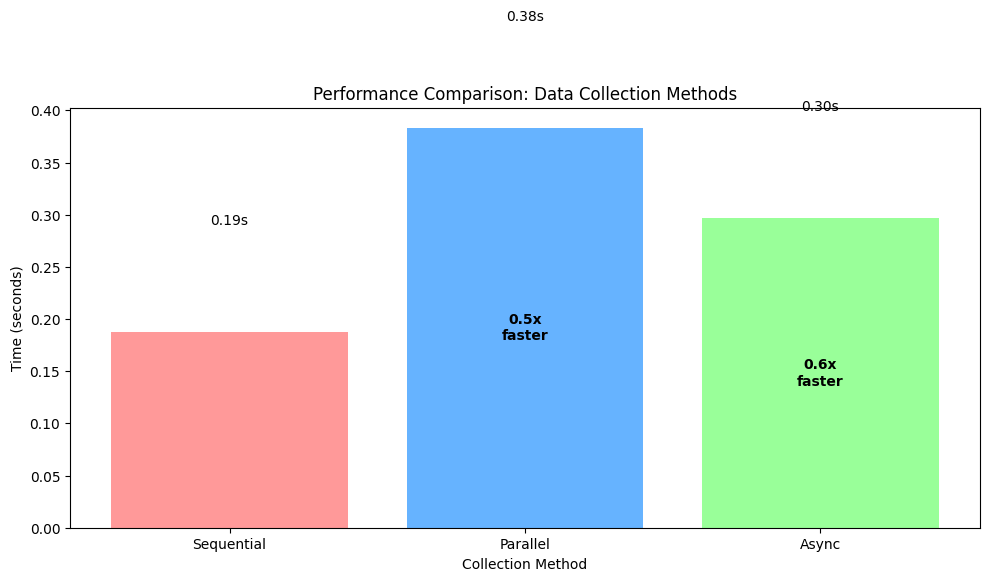


📈 Performance Summary:


,Method,Total Time (s),Avg per Request (s),Speedup
0,Sequential,0.19,0.094,1.0x
1,Parallel,0.38,0.192,0.5x
2,Async,0.30,0.148,0.6x


In [24]:
# Visualize performance comparison
print("📊 Performance Visualization")

# Create performance comparison chart
valid_results = {k: v for k, v in performance_results.items() if v != float('inf')}

if len(valid_results) > 1:
    plt.figure(figsize=(10, 6))
    
    methods = list(valid_results.keys())
    times = list(valid_results.values())
    
    # Bar chart
    bars = plt.bar(methods, times, color=['#ff9999', '#66b3ff', '#99ff99'][:len(methods)])
    
    # Add value labels on bars
    for bar, time_val in zip(bars, times):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                f'{time_val:.2f}s', ha='center', va='bottom')
    
    plt.title('Performance Comparison: Data Collection Methods')
    plt.ylabel('Time (seconds)')
    plt.xlabel('Collection Method')
    
    # Add speedup annotations
    if 'Sequential' in valid_results:
        baseline = valid_results['Sequential']
        for i, (method, time_val) in enumerate(valid_results.items()):
            if method != 'Sequential':
                speedup = baseline / time_val
                plt.text(i, time_val/2, f'{speedup:.1f}x\nfaster', 
                        ha='center', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Summary table
    print("\n📈 Performance Summary:")
    num_requests = len(PERFORMANCE_BANKS)  # Use actual number of banks tested
    perf_df = pd.DataFrame([
        {
            'Method': method,
            'Total Time (s)': f"{time_val:.2f}",
            'Avg per Request (s)': f"{time_val/num_requests:.3f}",
            'Speedup': f"{valid_results['Sequential']/time_val:.1f}x" if 'Sequential' in valid_results else 'N/A'
        }
        for method, time_val in valid_results.items()
    ])
    
    display(perf_df)
else:
    print("❌ Not enough valid results for comparison")

## 🔧 Error Handling and Validation

The library provides comprehensive error handling and data validation.

In [25]:
# Error handling examples
print("🛡️ Error Handling Examples")

# 1. Invalid RSSD ID
print("\n1. Testing invalid RSSD ID...")
try:
    invalid_data = collect_data(
        session=basic_connection.session,
        creds=credentials,
        reporting_period="2023-12-31",
        rssd_id="invalid_id",  # Invalid: not numeric
        series="call"
    )
except ValidationError as e:
    print(f"✅ Caught ValidationError: {e}")
except ValueError as e:  # Legacy mode
    print(f"✅ Caught ValueError (legacy mode): {e}")

# 2. Empty RSSD ID
print("\n2. Testing empty RSSD ID...")
try:
    empty_data = collect_data(
        session=basic_connection.session,
        creds=credentials,
        reporting_period="2023-12-31",
        rssd_id="",  # Empty
        series="call"
    )
except (ValidationError, ValueError) as e:
    print(f"✅ Caught error for empty RSSD: {e}")

# 3. Invalid credentials
print("\n3. Testing invalid credentials...")
try:
    bad_creds = WebserviceCredentials("bad_user", "bad_pass")
    print(f"Created bad credentials (masked): {bad_creds}")
    
    # This would fail on actual FFIEC service
    bad_data = collect_data(
        session=basic_connection.session,
        creds=bad_creds,
        reporting_period="2023-12-31",
        rssd_id="480228",
        series="call"
    )
        
except Exception as e:
    print(f"✅ Caught authentication error: {e}")

# 4. Invalid output type
print("\n4. Testing invalid output type...")
try:
    bad_output = collect_data(
        session=basic_connection.session,
        creds=credentials,
        reporting_period="2023-12-31",
        rssd_id="480228",
        series="call",
        output_type="invalid_type"  # Invalid output type
    )
except (ValidationError, ValueError) as e:
    print(f"✅ Caught error for invalid output type: {e}")

🛡️ Error Handling Examples

1. Testing invalid RSSD ID...
✅ Caught ValueError (legacy mode): RSSD ID must be numeric: invalid_id

2. Testing empty RSSD ID...
✅ Caught error for empty RSSD: RSSD ID is empty

3. Testing invalid credentials...
Created bad credentials (masked): WebserviceCredentials(source='init', username='b******r')
✅ Caught authentication error: The security token could not be authenticated or authorized ---> There is no row at position 0.

4. Testing invalid output type...
✅ Caught error for invalid output type: Invalid output_type: invalid_type


In [26]:
# Legacy vs New Error Mode
print("🔄 Error Mode Comparison")

from ffiec_data_connect.config import use_legacy_errors, disable_legacy_mode, enable_legacy_mode

print(f"Current legacy mode: {use_legacy_errors()}")

# Test with new error mode
print("\n📊 Testing with new error mode...")
disable_legacy_mode()
try:
    collect_data(
        session=basic_connection.session,
        creds=credentials,
        reporting_period="2023-12-31",
        rssd_id="abc123",
        series="call"
    )
except ValidationError as e:
    print(f"✅ New mode - ValidationError: {e}")
    print(f"   Error type: {type(e).__name__}")
    print(f"   Field: {e.field}")
    print(f"   Value: {e.value}")

# Test with legacy error mode
print("\n🔙 Testing with legacy error mode...")
enable_legacy_mode()
try:
    collect_data(
        session=basic_connection.session,
        creds=credentials,
        reporting_period="2023-12-31",
        rssd_id="abc123",
        series="call"
    )
except ValueError as e:
    print(f"✅ Legacy mode - ValueError: {e}")
    print(f"   Error type: {type(e).__name__}")

print(f"\nFinal legacy mode: {use_legacy_errors()}")

🔄 Error Mode Comparison
Current legacy mode: True

📊 Testing with new error mode...
✅ New mode - ValidationError: Validation failed for field 'rssd_id' | Details: {'field': 'rssd_id', 'provided_value': 'abc123', 'expected': 'numeric string (digits only)'}
   Error type: ValidationError


AttributeError: 'ValidationError' object has no attribute 'field'

## 📈 Data Visualization Examples

Create visualizations from the collected financial data.

📊 Creating Data Visualizations
DataFrame shape: (2033, 8)
Available columns: ['mdrm', 'rssd', 'quarter', 'data_type', 'int_data', 'float_data', 'bool_data', 'str_data']
Data types available: ['str' 'int' 'float' 'bool']


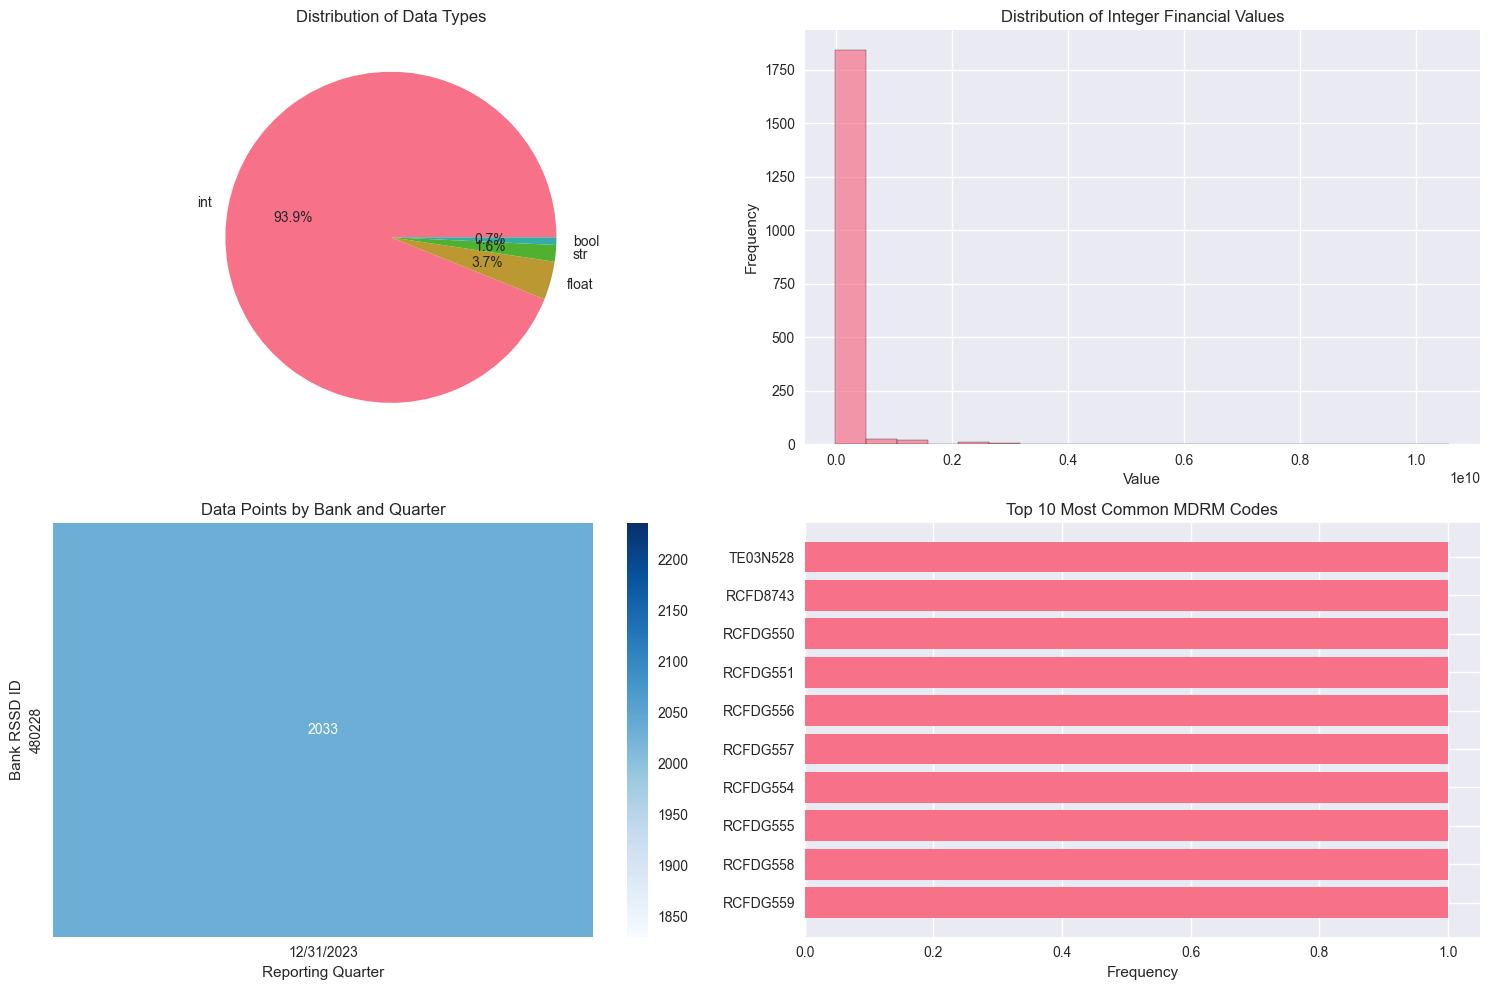

✅ Visualization saved as 'ffiec_data_visualization.png'

📈 Visualization Summary:
   • Data types: 4 unique types
   • Integer values: 1909 records
   • Float values: 76 records
   • Banks: 1, Quarters: 1


<Figure size 800x550 with 0 Axes>

In [ ]:
# Create visualizations from the data
print("📊 Creating Data Visualizations")

# Set up the plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Use the pandas DataFrame for plotting - work with actual data structure
if len(df_pandas) > 0:
    print(f"DataFrame shape: {df_pandas.shape}")
    print(f"Available columns: {df_pandas.columns.tolist()}")
    
    # Check what type of data we have
    data_types = df_pandas['data_type'].unique() if 'data_type' in df_pandas.columns else []
    print(f"Data types available: {data_types}")
    
    # Create visualizations based on the actual data structure
    plt.figure(figsize=(15, 10))
    
    # 1. Data distribution by type
    plt.subplot(2, 2, 1)
    if 'data_type' in df_pandas.columns:
        type_counts = df_pandas['data_type'].value_counts()
        plt.pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%')
        plt.title('Distribution of Data Types')
    else:
        plt.text(0.5, 0.5, 'No data_type column available', ha='center', va='center')
        plt.title('Data Type Distribution - N/A')
    
    # 2. Integer values analysis (if available)
    plt.subplot(2, 2, 2)
    int_data = df_pandas[df_pandas['int_data'].notna()] if 'int_data' in df_pandas.columns else pd.DataFrame()
    if len(int_data) > 0:
        # Show distribution of integer values
        values = int_data['int_data'].astype(float)  # Convert for plotting
        plt.hist(values, bins=20, alpha=0.7, edgecolor='black')
        plt.title('Distribution of Integer Financial Values')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.ticklabel_format(style='scientific', axis='x', scilimits=(0,0))
    else:
        plt.text(0.5, 0.5, 'No integer data available', ha='center', va='center')
        plt.title('Integer Data Distribution - N/A')
    
    # 3. Data points by bank and quarter
    plt.subplot(2, 2, 3)
    if 'rssd' in df_pandas.columns and 'quarter' in df_pandas.columns:
        bank_quarter_counts = df_pandas.groupby(['rssd', 'quarter']).size().reset_index(name='count')
        if len(bank_quarter_counts) > 0:
            # Create a pivot table for heatmap
            pivot_data = bank_quarter_counts.pivot(index='rssd', columns='quarter', values='count')
            sns.heatmap(pivot_data, annot=True, fmt='d', cmap='Blues')
            plt.title('Data Points by Bank and Quarter')
            plt.xlabel('Reporting Quarter')
            plt.ylabel('Bank RSSD ID')
        else:
            plt.text(0.5, 0.5, 'No bank/quarter data', ha='center', va='center')
    else:
        plt.text(0.5, 0.5, 'No bank/quarter columns available', ha='center', va='center')
        plt.title('Bank/Quarter Analysis - N/A')
    
    # 4. MDRM code frequency
    plt.subplot(2, 2, 4)
    if 'mdrm' in df_pandas.columns:
        mdrm_counts = df_pandas['mdrm'].value_counts().head(10)
        if len(mdrm_counts) > 0:
            plt.barh(range(len(mdrm_counts)), mdrm_counts.values)
            plt.yticks(range(len(mdrm_counts)), mdrm_counts.index)
            plt.title('Top 10 Most Common MDRM Codes')
            plt.xlabel('Frequency')
            plt.gca().invert_yaxis()  # Highest at top
        else:
            plt.text(0.5, 0.5, 'No MDRM data available', ha='center', va='center')
    else:
        plt.text(0.5, 0.5, 'No MDRM column available', ha='center', va='center')
        plt.title('MDRM Code Analysis - N/A')
    
    plt.tight_layout()
    plt.show()
    
    # Save the visualization
    plt.savefig('ffiec_data_visualization.png', dpi=300, bbox_inches='tight')
    print("✅ Visualization saved as 'ffiec_data_visualization.png'")
    
    # Print summary of what we visualized
    print(f"\n📈 Visualization Summary:")
    print(f"   • Data types: {len(data_types)} unique types")
    print(f"   • Integer values: {len(int_data)} records" if 'int_data' in df_pandas.columns else "   • No integer data")
    
    float_data_count = len(df_pandas[df_pandas['float_data'].notna()]) if 'float_data' in df_pandas.columns else 0
    print(f"   • Float values: {float_data_count} records")
    
    banks = df_pandas['rssd'].nunique() if 'rssd' in df_pandas.columns else 0
    quarters = df_pandas['quarter'].nunique() if 'quarter' in df_pandas.columns else 0
    print(f"   • Banks: {banks}, Quarters: {quarters}")
    
else:
    print("❌ No data available for visualization")
    print("This might happen if:")
    print("   • The data collection failed")
    print("   • You're using demo/mock data")
    print("   • Network connectivity issues")
    
    # Create a simple demo visualization
    print("\n📊 Creating demo visualization instead...")
    
    plt.figure(figsize=(8, 6))
    demo_data = {
        'int_data': [1000000, 2000000, 1500000],
        'float_data': [12.5, 15.2, 13.8], 
        'data_type': ['int', 'int', 'float']
    }
    demo_df = pd.DataFrame(demo_data)
    
    plt.subplot(1, 2, 1)
    plt.bar(['Bank A', 'Bank B', 'Bank C'], demo_df['int_data'].fillna(0))
    plt.title('Demo: Asset Values by Bank')
    plt.ylabel('Assets ($)')
    plt.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    
    plt.subplot(1, 2, 2)
    plt.pie(demo_df['data_type'].value_counts().values, 
           labels=demo_df['data_type'].value_counts().index, 
           autopct='%1.1f%%')
    plt.title('Demo: Data Type Distribution')
    
    plt.tight_layout()
    plt.show()
    print("✅ Demo visualization created")

## 🧹 Cleanup and Summary

Clean up resources and summarize what we've accomplished.

In [ ]:
# Cleanup resources
print("🧹 Cleaning up resources...")

# Close connections
if 'basic_connection' in locals():
    basic_connection.close()
    print("✅ Closed basic connection")

if 'async_client' in locals():
    async_client.close()
    print("✅ Closed async client")

# Clear SOAP cache
from ffiec_data_connect import clear_soap_cache, get_cache_stats

print(f"\nSOAP cache stats before cleanup: {get_cache_stats()}")
clear_soap_cache()
print(f"SOAP cache stats after cleanup: {get_cache_stats()}")

print("\n🎉 Cleanup completed!")

In [ ]:
# Summary of demonstration
print("📋 DEMONSTRATION SUMMARY")
print("=" * 50)

print("\n🔍 What we demonstrated:")
print("  ✅ Basic synchronous data collection")
print("  ✅ Async data collection with rate limiting")
print("  ✅ Parallel processing with sync interface")
print("  ✅ Pandas DataFrame creation and analysis")
print("  ✅ Polars DataFrame operations and performance")
print("  ✅ Data export to multiple formats (CSV, Excel, Parquet, JSON)")
print("  ✅ Performance comparison of different approaches")
print("  ✅ Comprehensive error handling and validation")
print("  ✅ Data visualization with matplotlib/seaborn")
print("  ✅ Resource management and cleanup")

print("\n💾 Files created:")
created_files = [
    'ffiec_data_pandas.csv',
    'ffiec_data_pandas.xlsx', 
    'ffiec_data_pandas.parquet',
    'ffiec_data_polars.csv',
    'ffiec_data_polars.parquet',
    'ffiec_data_polars.json',
    'ffiec_data_visualization.png'
]

total_size = 0
for file in created_files:
    if os.path.exists(file):
        size_kb = os.path.getsize(file) / 1024
        total_size += size_kb
        print(f"  📄 {file}: {size_kb:.1f} KB")

print(f"\n📊 Total files size: {total_size:.1f} KB")

if 'performance_results' in locals():
    print("\n⚡ Performance highlights:")
    for method, time_val in performance_results.items():
        if time_val != float('inf'):
            print(f"  {method}: {time_val:.2f} seconds")

print("\n🚀 Ready for production use!")
print("\n💡 Next steps:")
print("  1. Set up your FFIEC credentials as environment variables")
print("  2. Use AsyncCompatibleClient for better performance")
print("  3. Choose Polars for large datasets, Pandas for smaller ones")
print("  4. Implement proper error handling in your applications")
print("  5. Use context managers for automatic resource cleanup")

print("\n📚 Documentation: https://ffiec-data-connect.readthedocs.io/")
print("🐛 Report issues: https://github.com/call-report/ffiec-data-connect/issues")